In [ ]:
%matplotlib inline

import os
import pandas as pd
from pandas import DataFrame
from pandas import Series
import numpy as np
import matplotlib.pyplot as plt
import string
import re

from sklearn.model_selection import cross_val_score, train_test_split

from konlpy.tag import Okt
# from konlpy.tag import Mecab 
from kss import split_sentences   
#from pykospacing import spacing
from gensim.models import Word2Vec

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.python.keras.layers import Input,Conv2D, MaxPool2D, MaxPooling1D
from tensorflow.python.keras import regularizers
from tensorflow.keras.layers import Embedding, Dense,GRU,Flatten, LSTM,Conv1D, GlobalMaxPooling1D, Dropout, GlobalAveragePooling1D

from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from kerastuner.tuners import RandomSearch # 랜덤서치를 합니다

In [ ]:
data = pd.read_excel('준지도예시.xlsx')
data=data[['review', 'target']]
data

# 데이터 줄이기

In [ ]:
def reduce_memory_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024**2 
    
    return df

In [4]:
data=reduce_memory_usage(data)

# train, test data 정의

In [8]:
train=data[:200]
test=data[200:330]

train['mark'] = 'train'
test['target'] = 0 
test['mark']='test'

/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_2830/3090602481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['mark'] = 'train'
/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_2830/3090602481.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['target'] = 0
/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_2830/3090602481.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [9]:
df=pd.concat([train,test])
df

,review,target,mark
0,야외웨딩촬영 최소화하자했는데 계속 욕심나요 일에 서울숲에서 야외웨딩촬영 예정이라 집...,0,train
1,휘닉스파크 렌탈샵 추천좀요 좋은곳 있나요 남자 둘이라 옷은 안 이뻐도 듀 요 렌탈샵...,1,train
2,hello inside lg 헬로렌탈 공기청정기 아는 만큼 깨끗해져요 lg헬로비전 ...,0,train
3,헬리오시티 억대 거래의 진실은 뭐야 국평 억대에 거래됐다면서 썰 돌던데 개구라야 증...,0,train
4,이 정도 떨어졌으면 국평 평이고 년 억 년 억 최고가 년 억 최고가 대비해서 억 빠...,0,train
...,...,...,...
324,동네미용실에서 머리 숱쳤는뎈 가격 원 카드는 원 가격 개 싼 대신 머리 섹션 안나누...,0,test
325,연애중인데 이건 헤어지는게 맞겠지 이제 사귄지 일 정도 된 동갑 커플인데 처음에 일...,0,test
326,광교중앙역 국평 실거래가 대장은 아니지만 그래도 대드캣 끝나고 하향안정화 되나보네 ...,0,test
327,구축에 가성비 원룸이라 좀 누추하기도 하고 쓰레기 처리 같은 거 생각하면 친구들 별...,0,test


# 전처리+토큰화
- 띄어쓰기 필요.. 안돌아가..요..


In [10]:
# 전처리 후 혹시나 있을 짧은 (분석에는 불필요한) 행은 삭제합니다
# 문단단위면 없을 것으로 생각되긴 합니다 (문장단위면 안녕!, 어서와! 이런 쓸데없는 문장들이 있습니다)

LENGTH = 10 # 길이 지정해줍니다

count = 0
for i in df['review']:
    if len(i) < LENGTH:
        count+=1
        print(i)
print(count)
print('짧은 글 비율:',np.round(count/len(df),4))

0
짧은 글 비율: 0.0


In [11]:
ix = df['review'].str.len() < LENGTH # 짧은 리뷰 표시 후 제거
df = df.loc[~ix]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329 entries, 0 to 328
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   review  329 non-null    category
 1   target  329 non-null    int64   
 2   mark    329 non-null    object  
dtypes: category(1), int64(1), object(1)
memory usage: 19.0+ KB


In [12]:
okt = Okt() 

def preprocess_okt(text):
    #     text = spacing(text) # 띄어쓰기 보정 위에서 했으면 필요없습니다
    pos_words = okt.pos(text, stem=True)
    words = [word for word, tag in pos_words if tag in ['Noun', 'Adjective', 'Verb', 'KoreanParticle', 'VerbPrefix'] ]
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','것','수','있다','않다','이다','이었다', '안','억','이건','정도','개']
    stopped_words = [w for w in words if not w in stopwords]
    return ', '.join(stopped_words)

In [13]:
df['review_token']=df['review'].apply(preprocess_okt)
df['review_token']= [[_] for _ in df.review_token]

#빈 값 확인
empty_index = [index for index, sentence in zip(df.index,df['review_token']) if len(sentence) < 1]
print(empty_index) 

df

[]


,review,target,mark,review_token
0,야외웨딩촬영 최소화하자했는데 계속 욕심나요 일에 서울숲에서 야외웨딩촬영 예정이라 집...,0,train,"[야외, 웨딩촬영, 최소, 화하다, 계속, 욕심, 요, 일, 서울숲, 야외, 웨딩촬..."
1,휘닉스파크 렌탈샵 추천좀요 좋은곳 있나요 남자 둘이라 옷은 안 이뻐도 듀 요 렌탈샵...,1,train,"[휘닉스, 파크, 렌탈샵, 추천, 좋다, 곳, 남자, 둘, 옷, 이쁘다, 듀, 요,..."
2,hello inside lg 헬로렌탈 공기청정기 아는 만큼 깨끗해져요 lg헬로비전 ...,0,train,"[헬로, 렌탈, 공기청정기, 알다, 만큼, 깨끗해지다, 헬로비전, 추다, 때, 추위..."
3,헬리오시티 억대 거래의 진실은 뭐야 국평 억대에 거래됐다면서 썰 돌던데 개구라야 증...,0,train,"[헬리, 시티, 억대, 거래, 진실, 뭐, 국평, 억대, 거래, 돼다, 써다, 돌다..."
4,이 정도 떨어졌으면 국평 평이고 년 억 년 억 최고가 년 억 최고가 대비해서 억 빠...,0,train,"[떨어지다, 국평, 평이, 년, 년, 최고, 년, 최고, 대비, 빠지다, 요즘, 금..."
...,...,...,...,...
324,동네미용실에서 머리 숱쳤는뎈 가격 원 카드는 원 가격 개 싼 대신 머리 섹션 안나누...,0,test,"[미용실, 머리, 숱쳤는뎈, 가격, 원, 카드, 원, 가격, 싸다, 대신, 머리, ..."
325,연애중인데 이건 헤어지는게 맞겠지 이제 사귄지 일 정도 된 동갑 커플인데 처음에 일...,0,test,"[연애, 헤어지다, 맞다, 이제, 사귀다, 일, 되다, 동갑, 커플, 처음, 때, ..."
326,광교중앙역 국평 실거래가 대장은 아니지만 그래도 대드캣 끝나고 하향안정화 되나보네 ...,0,test,"[광교, 중앙, 역, 국평, 실, 거래, 대장, 아니다, 대드캣, 끝나다, 하향, ..."
327,구축에 가성비 원룸이라 좀 누추하기도 하고 쓰레기 처리 같은 거 생각하면 친구들 별...,0,test,"[구축, 가성, 비, 원룸, 누, 추하다, 쓰레기, 처리, 같다, 거, 생각, 친구..."


# 정수 인코딩
- https://wikidocs.net/69141

In [14]:
total_token= []
for _ in df.review_token:
    total_token.extend(_)
total_token

['야외, 웨딩촬영, 최소, 화하다, 계속, 욕심, 요, 일, 서울숲, 야외, 웨딩촬영, 예정, 집, 근처, 가깝다, 셀프, 드레스, 샵, 투어, 다녀오다, 릴, 드레스, 검색, 눈, 여기다, 보다, 곳, 생각, 드레스, 종류, 많다, 다양하다, 소품, 다행하다, 고르다, 실외, 마스크, 벗다, 되다, 조금, 마음, 편하다, 찍, 듯, 데, 토요일, 사람, 많다, 생각, 설레다, 조금, 부끄럽다, 같다, 최소, 화하다, 뭔가, 소품, 욕심, 나다, 드레스, 마음, 들다, 실외, 착용, 구두, 못, 빌리다, 아쉽다, 가성, 비, 좋다, 곳, 없다, 생각, 추천, 드레스, 벌, 베일, 부케, 부, 토니, 등, 만원, 대면, 충분하다, 만족하다, 공유, 드리다',
 '휘닉스, 파크, 렌탈샵, 추천, 좋다, 곳, 남자, 둘, 옷, 이쁘다, 듀, 요, 렌탈샵, 담합, 가격, 똑같다, 그냥, 자고, 갈다, 자다, 곳, 그게, 아니다, 휘팍, 가깝다, 곳, 해, 래야, 반납, 편하다',
 '헬로, 렌탈, 공기청정기, 알다, 만큼, 깨끗해지다, 헬로비전, 추다, 때, 추위, 걱정, 따뜻하다, 봄, 오다, 공기, 걱정, 날씨, 따뜻하다, 활동, 좋다, 공기, 정체, 되어다, 미세먼지, 초미세먼지, 봄, 되다, 늘, 소식, 전해지다, 중국, 건너오다, 황사, 건강, 걱정, 아니다, 되다, 이렇다, 걱정, 달, 살다, 아니다, 야외, 공기, 없다, 실내, 공기, 깨끗하다, 상콤, 콤, 맛있다, 공기, 숨쉬다, 싶다, 공기, 주문, 걸다, 싶다, 효, 다나카, 음성, 지원, 필요, 오이, 시쿠, 나래, 모에모에, 꿍꿍, 꿍, 전자, 오브, 컬렉션, 에어로, 퍼, 처, 헬로, 렌탈, 가전제품, 렌탈, 가격, 비교, 헬로, 렌탈, 본사, 공식, 몰다, 가전제품, 렌탈, 가격, 비교, 및, 할인, 혜택, 안내, 냉장고, 세탁기, 안마, 의자, 정수기, 공기청정기, 가전, 렌탈, 독특, 확인, 헬로, 렌탈, 막상, 공기청정기, 사려, 많다, 다양하다, 제품, 중, 우리, 집, 맞다, 공기

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(total_token) 
word2idx = tokenizer.word_index
idx2word = {value : key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(total_token)
print(encoded[:2])

[[1980, 4383, 829, 2507, 112, 266, 43, 27, 6012, 1980, 4383, 720, 22, 646, 677, 2508, 2204, 4384, 1270, 678, 6013, 2204, 410, 200, 679, 2, 48, 8, 2204, 1368, 17, 287, 1628, 1797, 398, 4385, 2205, 3460, 1, 142, 81, 146, 3461, 190, 237, 2907, 26, 17, 8, 1629, 142, 1483, 4, 829, 2507, 786, 1628, 266, 59, 2204, 81, 19, 4385, 4386, 2908, 16, 680, 882, 50, 30, 3, 48, 5, 8, 57, 2204, 2909, 6014, 6015, 1176, 6016, 93, 78, 2509, 513, 514, 551, 49], [6017, 1048, 1271, 57, 3, 48, 157, 515, 619, 115, 4387, 43, 1271, 6018, 71, 915, 63, 1100, 164, 14, 48, 476, 7, 6019, 677, 48, 87, 1981, 2206, 146]]


In [16]:
vocab_size = len(word2idx) + 1 
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 10757


# 네거티브 샘플링을 통한 데이터 셋 구성

- https://wikidocs.net/69141

In [17]:
from tensorflow.keras.preprocessing.sequence import skipgrams
# 네거티브 샘플링
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

In [18]:
# 첫번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
# 0은 네거티브, 1은 주변 단어의 관계를 가지는 경우
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(생각 (8), 되다 (1)) -> 1
(들다 (19), 부끄럽다 (1483)) -> 1
(서울숲 (6012), 나은 (3004)) -> 0
(가성 (50), 추천 (57)) -> 1
(부케 (6015), 추천 (57)) -> 1


In [19]:
print('전체 샘플 수 :',len(skip_grams))

전체 샘플 수 : 329


# Skip-Gram with Negative Sampling(SGNS) 구현하기

- https://wikidocs.net/69141

In [20]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

In [21]:
embedding_dim = 100

# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding  = Embedding(vocab_size, embedding_dim)(c_inputs)

dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

for epoch in range(1, 10):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)  
    print('Epoch :',epoch, 'Loss :',loss)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 100)       1075700     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       1075700     ['input_2[0][0]']                
                                                                                              

In [22]:
import gensim

f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embedding_dim))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

# 모델 로드
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)
w2v.most_similar(positive=['냉장고'])

[('디오스', 0.9037387371063232),
 ('식기세척기', 0.8694440722465515),
 ('베이지', 0.868343710899353),
 ('증', 0.8629862070083618),
 ('컬렉션', 0.8619970679283142),
 ('엘지', 0.8604196310043335),
 ('가전제품', 0.8529177904129028),
 ('에어로', 0.8527141213417053),
 ('가전', 0.8463902473449707),
 ('세트', 0.8434395790100098)]

# 훈련에 들어갈 train, test 셋 만들기

In [23]:
#삭제후 index 리셋 (삭제되는 글이 있으면 뒤에 코드에서 에러)
df = df.reset_index().drop('index',axis=1)

### 필요 없는 것 삭제
train_=df[df.mark=='train']
test_=df[df.mark=='test']
target=pd.DataFrame({'target':train_.target})

train_ = train_.drop(['review_token','mark','target'], axis =1)
test_ = test_.drop(['review_token','mark', 'target'], axis = 1)
train_ = train_.reset_index(drop=True)
test_ = test_.reset_index(drop=True)


def token(x):
    total_token= []
    for n, _ in enumerate(x.review):
        total_token.append( _)
    return total_token

#target = np.array(target.values).ravel() # ravel을 하지 말아야하는건가.. 
train = token(train_)
test= token(test_)

In [24]:
print(len(train), len(target), len(test))

200 200 129


In [25]:
train[0]

'야외웨딩촬영 최소화하자했는데 계속 욕심나요 일에 서울숲에서 야외웨딩촬영 예정이라 집근처 가까운 셀프 드레스 샵 투어 다녀왔어요 릴 드레스 검색하고 눈여겨 봤던 곳인데 생각보다 드레스 종류도 많고 다양한 소품이 있어서 다행히 잘골랐습니다 실외에선 마스크도 벗어도 된다하고 그나마 조금은 마음 편하게 찍을 수 있을 듯한데 토요일이라 사람들이 많을것을 생각하니 설레면서도 조금은 부끄러울것 같아요 그리고 최소화하자했는데 뭔가 소품에도 욕심나고 드레스는 너무너무 마음에 드는데 실외착용으로 구두는 못빌렸는데 아쉬워요 하지만 가성비 좋게 이만한곳 없다고 생각하고 추천합니다 드레스 벌 베일 부케부토니에 등 만원대면 충분히 만족하여 공유드려요'

# 모델에 들어갈 데이터 정수화

In [26]:
tokenizer = Tokenizer()             
tokenizer.fit_on_texts(train)
tokenizer 

In [27]:
print("len(tokenizer) :",len(list(tokenizer.word_index)))

len(tokenizer) : 25807


In [28]:
# 코드 출처  4) 정수인코딩 부분
# https://wikidocs.net/44249

# 희귀 단어를 삭제할 지 여부를 결정하는 부분입니다 
# (모델 학습에 불필요하다고 생각된 단어들을 삭제한다는 의미입니다)
# threshold에 따라 어느정도에서 짜를 지 선택할 수 있고
# 그에 따라 토크나이저에서의 VOCAB_SIZE가 정해집니다

threshold = 1
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 tokenizer.word_counts.items() 통해 key(단어)와 value(빈도수)로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
VOCAB_SIZE = total_cnt - rare_cnt + 2
print('최종 단어 집합의 크기 :',VOCAB_SIZE)

단어 집합(vocabulary)의 크기 : 25807
등장 빈도가 0번 이하인 희귀 단어의 수: 0
단어 집합에서 희귀 단어의 비율: 0.0
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.0
최종 단어 집합의 크기 : 25809


In [29]:
# token화
tokenizer = Tokenizer(VOCAB_SIZE, oov_token = 'OOV') # 자주나오는 상위 vocab_size만 학습, 학습되지 않은 단어는 1로 처리
tokenizer.fit_on_texts(train)
word_index = tokenizer.word_index
print(len(word_index))

25808


In [30]:
# OOV 설정했기 때문에 VOCAB_SIZE 초과하는 단어들은 OOV 1 정수로 인코딩 처리됩니다.
#Training set token with text_to_sequences.
x_train_tokens = tokenizer.texts_to_sequences(train)
test_tokens = tokenizer.texts_to_sequences(test)

# pos tagging 된거 길이 = 토큰화 된거 길이 는 같아야합니다
print(len(train), len(x_train_tokens))
print(len(test), len(test_tokens))

x_train_tokens[50]

200 200
129 129


[2083,
 2087,
 89,
 11043,
 11044,
 1852,
 11045,
 681,
 11046,
 885,
 2339,
 885,
 2339,
 11047,
 11048,
 11049,
 1853,
 33,
 11050,
 3847,
 393,
 11051,
 4212,
 19,
 11052,
 4212]

# 제일 긴 문장의 길이로 padding 맞추기
- 적정한 길이로 문장 자르기

문장의 최대 길이 : 2232
문장의 평균 길이 : 259.165


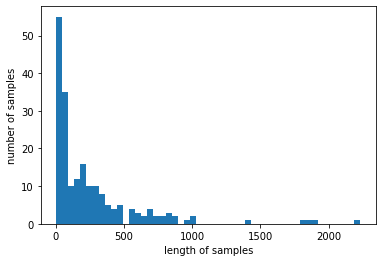

In [31]:
# 코드 출처  6) 제로 패딩
# https://wikidocs.net/44249

print('문장의 최대 길이 :',max(len(l) for l in x_train_tokens))
print('문장의 평균 길이 :',sum(map(len, x_train_tokens))/len(x_train_tokens))
plt.hist([len(s) for s in x_train_tokens], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [32]:
# 삭제되는 비중을 알려주는 함수
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [33]:
max_len = 500  # 이 부분에 숫자를 바꾸며 적정 길이를 선택합니다
below_threshold_len(max_len, x_train_tokens)
count = 0
cutted = 0

for i in range(len(x_train_tokens)):
    s = x_train_tokens[i]
    count += 1
    if len(s) > max_len:
        cutted += 1
        
print('Total number of samples:', count)
print('길이 짤리는 문장 개수, 비율:', cutted, (cutted/count)*100)

전체 샘플 중 길이가 500 이하인 샘플의 비율: 85.0
Total number of samples: 200
길이 짤리는 문장 개수, 비율: 30 15.0


In [34]:
MAX_LEN = max_len # 정해준 길이에 맞춰 제로패딩해줍니다

#패딩
x_train_pad = pad_sequences(x_train_tokens, maxlen=MAX_LEN)
test_pad = pad_sequences(test_tokens, maxlen=MAX_LEN)
#Zero is added before the values given in the padding operation.
print("x_train_pad.shape :",x_train_pad.shape)
print("test_pad.shape :",test_pad.shape)
print('='*92)
print("x_train_tokens :",x_train_tokens[0])
print("x_train_pad :",x_train_pad[0])

x_train_pad.shape : (200, 500)
test_pad.shape : (129, 500)
x_train_tokens : [3095, 3096, 40, 5939, 433, 5940, 3095, 3097, 5941, 1192, 5942, 1193, 5943, 2068, 1194, 5944, 1193, 3098, 3099, 5945, 5946, 388, 1193, 3100, 350, 171, 5947, 77, 973, 5948, 5949, 5950, 5951, 5952, 275, 1536, 389, 351, 5953, 2, 390, 5954, 5955, 391, 5956, 5957, 5958, 1536, 5959, 27, 23, 3096, 476, 5960, 5961, 5962, 2069, 434, 5963, 5964, 5965, 5966, 3101, 68, 47, 319, 5967, 526, 256, 2070, 1193, 3102, 5968, 5969, 164, 5970, 974, 5971, 5972]
x_train_pad : [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0 

In [35]:
# 토큰을 다시 문자로 --> 쓸일 없지만.. 혹시나 나중에 쓰일까봐 넣어놓음
# idx = tokenizer.word_index
# inverse_map = dict(zip(idx.values(), idx.keys()))

# #토큰을 다시 텍스트로!
# def tokens_to_string(tokens):
#     words = [inverse_map[token] for token in tokens if token!=0]
#     text = ' '.join(words)
#     return text

# tokens_to_string(x_train_tokens[50])

# 이제 Word2vec을 불러와서 모델 데이터에 적용

In [36]:
#Word2Vec 파일 불러오기
word2vec = {}
with open('vectors.txt', encoding='UTF-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec

In [37]:
num_words = len(list(tokenizer.word_index))

#임베딩 매트릭스(word2vec이랑 맞추기)
embedding_matrix = np.random.uniform(-1, 1, (VOCAB_SIZE, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < num_words:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
embedding_matrix.shape

(25809, 100)

In [38]:
embedding_matrix[3]

array([ 0.34910133,  0.08607111, -0.17975557,  0.25088623,  0.21150644,
        0.14326507, -0.11754958, -0.30104312, -0.74741465, -0.04290602,
       -0.19579343, -0.06501253, -0.18920389, -0.07561588, -0.34860393,
        0.18532825,  0.11974408, -0.19071405,  0.29477695, -0.19274524,
       -0.33188784, -0.19581868,  0.32550284, -0.20006239, -0.01028258,
        0.18375741, -0.22389348,  0.34641442, -0.13668723,  0.58395839,
        0.19064234,  0.0386048 ,  0.12866502, -0.39512816, -0.09486471,
        0.38152492,  0.17672555,  0.14766234, -0.36028466,  0.40990338,
       -0.30263698, -0.20948268,  0.36066288, -0.04376269, -0.26981553,
        0.26447988,  0.06133792, -0.08452154,  0.0570284 ,  0.23186685,
        0.26615915,  0.21860051,  0.37139428,  0.23717721,  0.28170365,
       -0.29322919,  0.37349299, -0.08431455, -0.2091435 , -0.30852816,
       -0.19956829,  0.07234303, -0.01780616,  0.08989616,  0.24825403,
       -0.28849435, -0.41699007, -0.10054071,  0.31116027,  0.33

# 드디어 모델 적용!!
## 준지도 학습 
- 1) LSTM을 돌려서 예측값을 추출
- 2) CNN 돌려서 예측값을 추출
- 3) LSTM vs. CNN predict에서 일치하지 않은 것들을 GRU의 Test Set으로 보내고 일치하는 것은 train셋으로 넣는다
** tuner Search 기능에 validation set을 지정해주는 기능이 존재함

# Model 1: LSTM
## project_name 꼭꼭 새로 정해줘야함!!

In [39]:
print(len(x_train_pad), len(target))

200 200


In [40]:
target = target.astype(np.float32)
target['target'].value_counts()

0.0    114
1.0     86
Name: target, dtype: int64

In [41]:
# tuner version
# 밑에 설정된 step의 크기, 노드 학습rate dropout rate 의 min,max범위 등은 직접 변경하셔도 됩니다
EMBEDDING_DIM=100
def build_lstm(hp):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix],input_length=MAX_LEN, trainable=False))
    model.add(LSTM(units=hp.Int('units1', min_value=4, max_value=128,step=16)))
    model.add(Dense(units=hp.Int('units2', min_value=32, max_value=256,step=32), activation='relu'))
    model.add(Dropout(rate = hp.Float('drop_out_rate', 0.1, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-1, sampling='log')),
                  loss = 'binary_crossentropy',
                  metrics=['acc'])
    return model

In [42]:
tuner = RandomSearch(
    build_lstm,
    objective='val_acc',
    max_trials = 15,  #  total number of trials 총 15번 랜덤서치를 합니다
    executions_per_trial=2, # the number of models that should be built and fit for each trial
    project_name ='lstm5') # 현재 주피터파일이 있는 위치에 lstm1이라는 폴더가 생성됩니다. 

# ***모델 다시 돌릴때 주의사항
# 모델을 다시 돌릴땐 project_name을 바꾸던지 현재 위치(폴더)를 바꿔야 돌아갑니다
# 아니면 이전에 만들어진 파일을 삭제하고 다시 돌리면 됩니다
# 폴더 안에는 test해본 모델들의 정보가 기록됩니다

In [43]:
tuner.search_space_summary() # 랜덤서치의 범위를 요약해서 보여줍니다

Search space summary
Default search space size: 4
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
drop_out_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [44]:
# 모델 input으로 정수인코딩 된 train 데이터와 라벨이 들어갑니다
# epoch, validation_split, patience 등 하이퍼파라미터들을 원하시는대로 조정합니다 

tuner.search(x_train_pad, target, epochs=15, validation_split=0.25, 
             callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=3)]) 

In [45]:
tuner.results_summary() 

# Score는 val_acc 를 의미합니다
# 탑 10개 모델의 정보를 출력해줍니다

Results summary
Results in ./lstm5
Showing 10 best trials
Objective(name="val_acc", direction="max")

Trial 07 summary
Hyperparameters:
units1: 100
units2: 128
drop_out_rate: 0.2
learning_rate: 0.0007137792180870341
Score: 0.6500000059604645

Trial 04 summary
Hyperparameters:
units1: 68
units2: 256
drop_out_rate: 0.5
learning_rate: 0.0010134724629631065
Score: 0.6500000059604645

Trial 09 summary
Hyperparameters:
units1: 116
units2: 224
drop_out_rate: 0.5
learning_rate: 0.0007971024010324577
Score: 0.6300000250339508

Trial 01 summary
Hyperparameters:
units1: 4
units2: 32
drop_out_rate: 0.4
learning_rate: 0.01220074539121311
Score: 0.6299999952316284

Trial 02 summary
Hyperparameters:
units1: 4
units2: 192
drop_out_rate: 0.1
learning_rate: 0.0007464668252860458
Score: 0.6200000047683716

Trial 10 summary
Hyperparameters:
units1: 36
units2: 256
drop_out_rate: 0.1
learning_rate: 0.00013383622325835876
Score: 0.6200000047683716

Trial 03 summary
Hyperparameters:
units1: 4
units2: 160
drop

In [46]:
# 가장 성능이 좋았던 모델을 저장해줍니다 
lstm_best_model = tuner.get_best_models(num_models=1)[0]

# Model 2: CNN

In [47]:
def build_cnn(hp):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix],input_length=MAX_LEN, trainable=False))
    model.add(Dropout(rate = hp.Float('drop_out_rate1', 0.1, 0.5, step=0.1)))
    
    filters_ = hp.Int('filters', 16, 128, step=32)
    kernel_size_ = hp.Choice('kernerl_size',values=[2,3,4,5])
    model.add(Conv1D(filters = filters_, kernel_size = kernel_size_,
                     strides = 1,padding='valid', activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(units=hp.Int('units', min_value=16, max_value=256,step=32), activation='relu'))
    model.add(Dropout(rate = hp.Float('drop_out_rate2', 0.1, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-1, sampling='log')),
                  loss = 'binary_crossentropy',
                  metrics=['acc'])
    return model

In [48]:
tuner = RandomSearch(
    build_cnn,
    objective='val_acc',
    max_trials = 15,  #  total number of trials
    executions_per_trial=2, # the number of models that should be built and fit for each trial
    project_name ='cnn6')

In [49]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
drop_out_rate1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
kernerl_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 5], 'ordered': True}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
drop_out_rate2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [50]:
tuner.search(x_train_pad,target, epochs=15, validation_split=0.25, 
             callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=3)]) 

Trial 15 Complete [00h 00m 09s]
val_acc: 0.6200000047683716

Best val_acc So Far: 0.6400000154972076
Total elapsed time: 00h 01m 45s


In [51]:
tuner.results_summary()

Results summary
Results in ./cnn6
Showing 10 best trials
Objective(name="val_acc", direction="max")

Trial 03 summary
Hyperparameters:
drop_out_rate1: 0.4
filters: 16
kernerl_size: 4
units: 16
drop_out_rate2: 0.4
learning_rate: 0.0033528888030504678
Score: 0.6400000154972076

Trial 13 summary
Hyperparameters:
drop_out_rate1: 0.30000000000000004
filters: 48
kernerl_size: 3
units: 48
drop_out_rate2: 0.5
learning_rate: 0.011781455875415684
Score: 0.6400000154972076

Trial 04 summary
Hyperparameters:
drop_out_rate1: 0.1
filters: 112
kernerl_size: 3
units: 208
drop_out_rate2: 0.4
learning_rate: 0.0005853998549224164
Score: 0.6399999856948853

Trial 10 summary
Hyperparameters:
drop_out_rate1: 0.4
filters: 80
kernerl_size: 2
units: 240
drop_out_rate2: 0.4
learning_rate: 0.000370743222844704
Score: 0.6300000250339508

Trial 02 summary
Hyperparameters:
drop_out_rate1: 0.5
filters: 48
kernerl_size: 5
units: 176
drop_out_rate2: 0.1
learning_rate: 0.017831198386942304
Score: 0.6299999952316284

Tr

In [52]:
cnn_best_model = tuner.get_best_models(num_models=1)[0]

# LSTM & CNN 1차 합의

# Model1. Threshold 정하기
- Train 데이터로

In [53]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
from sklearn.metrics import f1_score
model1_ = lstm_best_model.predict(x_train_pad) # model1 결과

scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (model1_.reshape((-1))>threshold).astype('int')
    m = f1_score(target.to_numpy().reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

7/7 [==============================] - 1s 67ms/step
0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

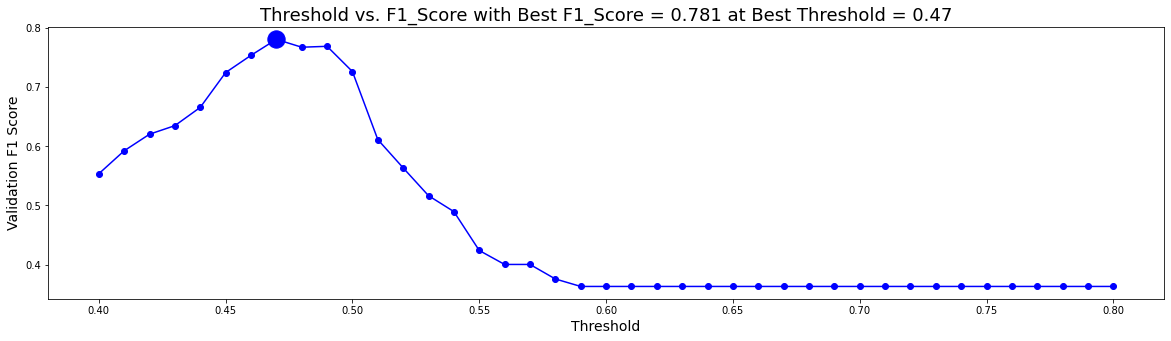

In [54]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

# Model2. Threshold 정하기

In [55]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
model2_ = cnn_best_model.predict(x_train_pad) # model2 결과

scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (model2_.reshape((-1))>threshold).astype('int')
    m = f1_score(target.to_numpy().reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

7/7 [==============================] - 0s 3ms/step
0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

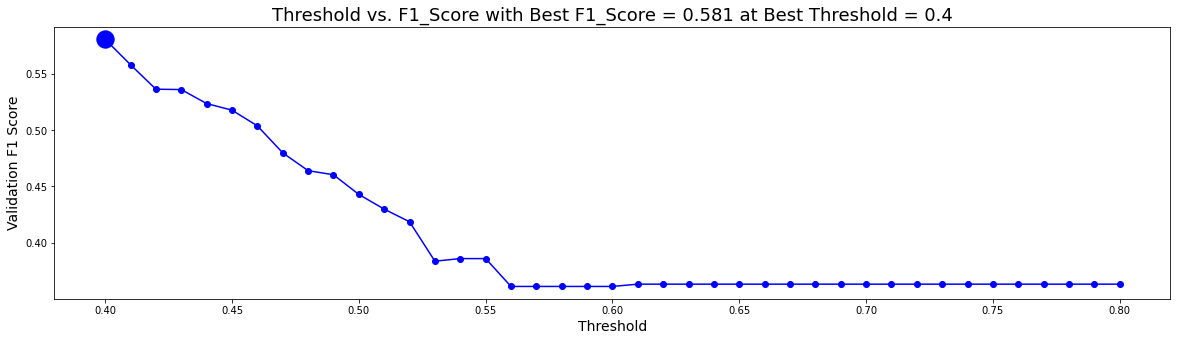

In [56]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

# 위 그래프에서 나온 threshold 기준으로 to_binary함수 변경

In [60]:
# 확률을 이산변수로
def model_1_to_binary(result):
    for i in range(len(result)):
        if result[i]>= 0.47: # threshold 조정이 필요하다면 여기서 조정하면 됩니다
            result[i] = 1
        else:
            result[i] = 0
    return result


def model_2_to_binary(result):
    for i in range(len(result)):
        if result[i]>= 0.4: # threshold 조정이 필요하다면 여기서 조정하면 됩니다
            result[i] = 1
        else:
            result[i] = 0
    return result


# 합의 여부를 출력
def agreement(df):
    x = df[0]
    y = df[1]
    if x == y:
        return True
    else:
        return False

In [61]:
#Test 데이터 넣어서 예측
model1_result = lstm_best_model.predict(test_pad) # model1 결과
model2_result = cnn_best_model.predict(test_pad) # model2 결과

model1_result = model_1_to_binary(model1_result) # 임계값을 기준으로 0,1로 변환
model2_result = model_2_to_binary(model2_result) # 임계값을 기준으로 0,1로 변환

#model1, model2 결과를 한 dataframe에 저장
result1 = pd.DataFrame(model1_result, columns=['model1']) 
result1['model2'] = model2_result
#result1.index = X_test_pad_index

# aggrement 함수로 합의 여부 출력
result1['accepted'] = result1.apply(agreement,axis=1) # 합의 여부 출력
result1['accepted'].value_counts() # True는 합의된 개수를 의미합니다

success = result1[result1['accepted']==True].index  # 합의된 행의 인덱스
fail = result1[result1['accepted']==False].index

print('Model_3에 Train으로 편입될 합의된 인덱스: ',len(success))
print('Model_3에 Test로 편입될 합의되지 않은 인덱스: ',len(fail))

5/5 [==============================] - 0s 4ms/step
Model_3에 Train으로 편입될 합의된 인덱스:  103
Model_3에 Test로 편입될 합의되지 않은 인덱스:  26


In [65]:
success

Int64Index([  0,   1,   2,   5,   7,   8,   9,  10,  11,  13,
            ...
            118, 119, 120, 121, 122, 123, 124, 125, 126, 127],
           dtype='int64', length=103)

# 최종 확정을 위한 새로운 데이터 생성

In [66]:
# 합의된 결과를 기반으로 test 데이터에서 해당하는 행을 추출
# success는 train에, fail은 test에 속하는 인덱스

# 최종 Train 데이터셋
test_agreement = test_['review'][success]
test_agreement=pd.DataFrame({'review': test_agreement})
final_train = pd.concat([train_, test_agreement], axis=0, ignore_index=True)
final_train=final_train.review
print(len(test_agreement),len(final_train))

#최종 Test 데이터셋
final_test= test_['review'][fail]
print(len(final_test))

# 최종 train target
y_agree = result1['model1'][success]
y_agree=pd.DataFrame({'target': y_agree})
final_target = pd.concat([target, y_agree], axis=0, ignore_index=True) 
print(len(final_target), len(y_agree))
print('전체 데이터:', f'{len(final_test)+len(final_train)}')

103 303
26
303 103
전체 데이터: 329


# 다시 정수화+패딩

In [67]:
tokenizer = Tokenizer()             
tokenizer.fit_on_texts(final_train)
print("len(tokenizer) :",len(list(tokenizer.word_index)))

threshold = 1
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 tokenizer.word_counts.items() 통해 key(단어)와 value(빈도수)로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
VOCAB_SIZE = total_cnt - rare_cnt + 2
print('최종 단어 집합의 크기 :',VOCAB_SIZE)

# token화
tokenizer = Tokenizer(VOCAB_SIZE, oov_token = 'OOV') # 자주나오는 상위 vocab_size만 학습, 학습되지 않은 단어는 1로 처리
tokenizer.fit_on_texts(final_train)
word_index = tokenizer.word_index
print(len(word_index))

# OOV 설정했기 때문에 VOCAB_SIZE 초과하는 단어들은 OOV 1 정수로 인코딩 처리됩니다.
#Training set token with text_to_sequences.
x_train_tokens = tokenizer.texts_to_sequences(final_train)
test_tokens = tokenizer.texts_to_sequences(final_test)

# pos tagging 된거 길이 = 토큰화 된거 길이 는 같아야합니다
print(len(train), len(x_train_tokens))
print(len(test), len(test_tokens))

x_train_tokens[20]

len(tokenizer) : 35614
단어 집합(vocabulary)의 크기 : 35614
등장 빈도가 0번 이하인 희귀 단어의 수: 0
단어 집합에서 희귀 단어의 비율: 0.0
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.0
최종 단어 집합의 크기 : 35616
35615
200 303
129 26


[10364,
 3244,
 10365,
 318,
 10366,
 697,
 10367,
 237,
 10368,
 4938,
 10369,
 10370,
 10371,
 4939,
 3074,
 1307,
 7,
 4939,
 10372,
 1878,
 4940,
 4941,
 10373,
 91,
 4598,
 98,
 2388,
 10374,
 10375,
 3245,
 10376,
 698,
 10377,
 3246,
 4942,
 4943,
 84,
 4944,
 37,
 309,
 466,
 1067,
 10378,
 1878,
 1520,
 10379,
 699,
 3246,
 4943,
 2389,
 50,
 10380,
 10381,
 10382,
 487,
 1066,
 10383,
 10384,
 10385,
 37,
 10386,
 1125,
 4941,
 4945,
 10387,
 10388,
 2390,
 2391,
 945,
 10389,
 10390,
 10391,
 441,
 466,
 4946,
 10392,
 10393,
 10394,
 43,
 10395,
 2390,
 365,
 4947,
 309,
 10396,
 10397,
 10398,
 262,
 10399,
 12,
 2392,
 2390,
 43,
 4948,
 10400,
 4949,
 10401,
 10402,
 10403,
 3246,
 10404,
 84,
 10405,
 10406,
 10407,
 10408,
 418,
 610,
 347,
 767,
 10409,
 10410,
 10411,
 10412,
 12,
 10413,
 10414,
 2391,
 292,
 3247,
 10415,
 2390,
 3248,
 3249,
 697,
 122,
 166,
 4643,
 10416,
 4950,
 10417]

문장의 최대 길이 : 9487
문장의 평균 길이 : 1041.5148514851485


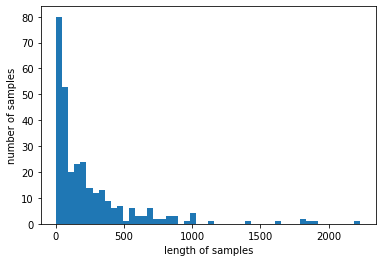

In [68]:
print('문장의 최대 길이 :',max(len(l) for l in final_train))
print('문장의 평균 길이 :',sum(map(len, final_train))/len(x_train_tokens))
plt.hist([len(s) for s in x_train_tokens], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [69]:
# 삭제되는 비중을 알려주는 함수
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))
    
max_len = 500  # 이 부분에 숫자를 바꾸며 적정 길이를 선택합니다
below_threshold_len(max_len, x_train_tokens)
count = 0
cutted = 0

for i in range(len(x_train_tokens)):
    s = x_train_tokens[i]
    count += 1
    if len(s) > max_len:
        cutted += 1
        
print('Total number of samples:', count)
print('길이 짤리는 문장 개수, 비율:', cutted, (cutted/count)*100)

# 패딩
MAX_LEN = max_len # 정해준 길이에 맞춰 제로패딩해줍니다

#패딩
x_train_pad = pad_sequences(x_train_tokens, maxlen=MAX_LEN)
test_pad = pad_sequences(test_tokens, maxlen=MAX_LEN)
#Zero is added before the values given in the padding operation.
print("x_train_pad.shape :",x_train_pad.shape)
print("test_pad.shape :",test_pad.shape)
print('='*92)
print("x_train_tokens :",x_train_tokens[0])
print("x_train_pad :",x_train_pad[0])

전체 샘플 중 길이가 500 이하인 샘플의 비율: 86.13861386138613
Total number of samples: 303
길이 짤리는 문장 개수, 비율: 42 13.861386138613863
x_train_pad.shape : (303, 500)
test_pad.shape : (26, 500)
x_train_tokens : [4461, 4462, 45, 8423, 651, 8424, 4461, 4463, 8425, 1233, 8426, 1766, 4464, 1767, 1768, 8427, 1766, 3001, 4465, 8428, 3002, 461, 1766, 4466, 401, 180, 8429, 98, 1234, 8430, 8431, 8432, 8433, 8434, 351, 1451, 462, 316, 4467, 2, 252, 8435, 8436, 430, 8437, 8438, 8439, 1451, 8440, 25, 22, 4462, 463, 8441, 8442, 8443, 1452, 402, 2225, 8444, 4468, 8445, 4469, 71, 39, 464, 8446, 652, 198, 1769, 1766, 3003, 8447, 8448, 124, 8449, 591, 8450, 8451]
x_train_pad : [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0   

In [70]:
num_words = len(list(tokenizer.word_index))

#임베딩 매트릭스(word2vec이랑 맞추기)
embedding_matrix = np.random.uniform(-1, 1, (VOCAB_SIZE, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < num_words:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
print(embedding_matrix.shape)
embedding_matrix[3]

(35616, 100)


array([ 0.34910133,  0.08607111, -0.17975557,  0.25088623,  0.21150644,
        0.14326507, -0.11754958, -0.30104312, -0.74741465, -0.04290602,
       -0.19579343, -0.06501253, -0.18920389, -0.07561588, -0.34860393,
        0.18532825,  0.11974408, -0.19071405,  0.29477695, -0.19274524,
       -0.33188784, -0.19581868,  0.32550284, -0.20006239, -0.01028258,
        0.18375741, -0.22389348,  0.34641442, -0.13668723,  0.58395839,
        0.19064234,  0.0386048 ,  0.12866502, -0.39512816, -0.09486471,
        0.38152492,  0.17672555,  0.14766234, -0.36028466,  0.40990338,
       -0.30263698, -0.20948268,  0.36066288, -0.04376269, -0.26981553,
        0.26447988,  0.06133792, -0.08452154,  0.0570284 ,  0.23186685,
        0.26615915,  0.21860051,  0.37139428,  0.23717721,  0.28170365,
       -0.29322919,  0.37349299, -0.08431455, -0.2091435 , -0.30852816,
       -0.19956829,  0.07234303, -0.01780616,  0.08989616,  0.24825403,
       -0.28849435, -0.41699007, -0.10054071,  0.31116027,  0.33

# 마지막 모델: GRU

In [71]:
def build_gru(hp):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix],input_length=MAX_LEN, trainable=False))
    model.add(GRU(units=hp.Int('units1', min_value=4, max_value=128,step=16)))
    model.add(Dense(units=hp.Int('units2', min_value=32, max_value=256,step=32), activation='relu'))
    model.add(Dropout(rate = hp.Float('drop_out_rate', 0.1, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-1, sampling='log')),
                  loss = 'binary_crossentropy',
                  metrics=['acc'])
    return model

In [72]:
tuner = RandomSearch(
    build_gru,
    objective='val_acc',
    max_trials = 10,  #  total number of trials
    executions_per_trial=1, # the number of models that should be built and fit for each trial
    project_name ='gru1')

In [73]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
drop_out_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [74]:
tuner.search(x_train_pad,final_target, epochs=15, validation_split=0.25, 
             callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=3)]) 

Trial 10 Complete [00h 00m 07s]
val_acc: 0.9736841917037964

Best val_acc So Far: 0.9868420958518982
Total elapsed time: 00h 01m 57s


In [75]:
gru_best_model = tuner.get_best_models(num_models=1)[0]

# THRESHOLD

In [76]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
model3_ = gru_best_model.predict(x_train_pad) # model2 결과

scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (model2_.reshape((-1))>threshold).astype('int')
    m = f1_score(target.to_numpy().reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

10/10 [==============================] - 0s 20ms/step
0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

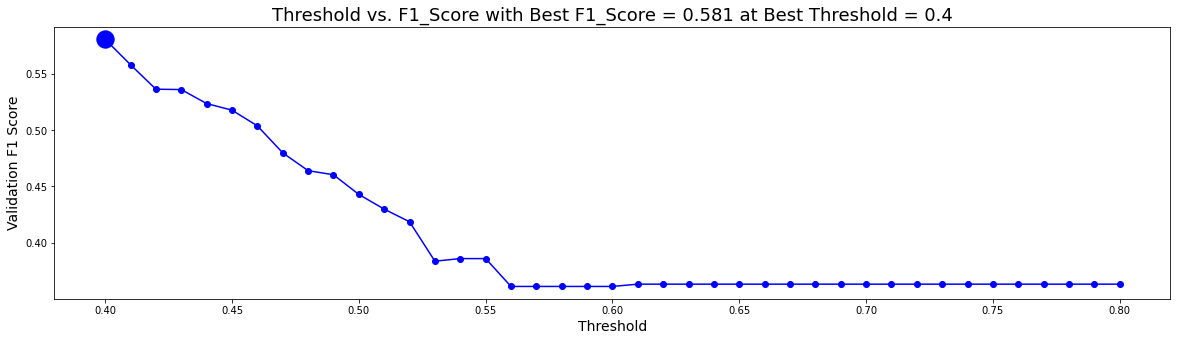

In [77]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [78]:
def model_3_to_binary(result):
    for i in range(len(result)):
        if result[i]>= 0.5: # threshold 조정이 필요하다면 여기서 조정하면 됩니다
            result[i] = 1
        else:
            result[i] = 0
    return result

In [79]:
#합의 안된 데이터들 최종 예측
result2 = gru_best_model.predict(test_pad)
result2 = model_3_to_binary(result2)
y_final_result = pd.DataFrame(result2, index=fail,columns=['target'])
print(y_final_result['target'].value_counts())

#전체 타겟
y_total = pd.concat([final_target,y_final_result])
print(len(y_total))

1/1 [==============================] - 0s 29ms/step
0.0    25
1.0     1
Name: target, dtype: int64
329


In [80]:
# 전체 데이터
total=pd.concat([final_train, final_test])
Fianl_data=pd.DataFrame({'review':total})
len(Fianl_data), Fianl_data

(329,
                                                 review
 0    야외웨딩촬영 최소화하자했는데 계속 욕심나요 일에 서울숲에서 야외웨딩촬영 예정이라 집...
 1    휘닉스파크 렌탈샵 추천좀요 좋은곳 있나요 남자 둘이라 옷은 안 이뻐도 듀 요 렌탈샵...
 2    hello inside lg 헬로렌탈 공기청정기 아는 만큼 깨끗해져요 lg헬로비전 ...
 3    헬리오시티 억대 거래의 진실은 뭐야 국평 억대에 거래됐다면서 썰 돌던데 개구라야 증...
 4    이 정도 떨어졌으면 국평 평이고 년 억 년 억 최고가 년 억 최고가 대비해서 억 빠...
 ..                                                 ...
 103  차알못이 독 사 차살때 이렇게 사면 후회는 안한다는데 중소형 시리즈 스포츠세단의 종...
 108  스파게티면 브랜드 추천해줄수 잇나요 이마트에서 살거 노브랜드 링귀니 폰타나 청정원 ...
 112              정수기 렌탈 어디가 저렴해 카드 실적할 생각은 없구 추천해줄수있을까
 116  근데 국평 가 아니라 국평 아니야 수능 안 치는 사람들도 있잖아 외국인 실업계 고등...
 128  잠실엘리트 국평 적정가 억 내년 하반기에는 올듯 내년에 잠실등기친다 풉 니집은 억아...
 
 [329 rows x 1 columns])

In [81]:
Fianl_data['target']=y_total
Fianl_data.target.value_counts()

0.0    240
1.0     89
Name: target, dtype: int64

In [82]:
# informative인 데이터 
X_informative = Fianl_data[Fianl_data['target']==1]  
X_informative.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89 entries, 1 to 26
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   review  89 non-null     category
 1   target  89 non-null     float32 
dtypes: category(1), float32(1)
memory usage: 11.9 KB


In [83]:
X_informative['target'].value_counts()

1.0    89
Name: target, dtype: int64

In [84]:
X_informative[['review','target']].sample(20)

,review,target
97,아침부터 자랑질요 새로 이사하고 침대도 사고 매트리스도 사고 침구도 주말에 가서 새...,1.0
48,자취 초기비용 할부할까 비상금대출받을까 수저하나까지 다 사야해서 거의 깨질거 같은데...,1.0
172,건조기 lg트롬세탁기건조기세트 설치하고 결합 할인 받았어요 lg전자 베스트렌탈샵 이...,1.0
37,성복역 심곡마을 힐스테이트 대형 or 분당 효자촌 국평 매매고민 제목대로 심곡마을 ...,1.0
150,큰 평형 vs 상급지 평대에서 국평으로 갈아타는 것과 동일 평수 상급지로 갈아타는 ...,1.0
60,자취하고 버는데 적금 아 더 늘리고싶은데 존나안된다 월세 보험비 뭐 안 하는데 식비...,1.0
131,평생 부모님 생활비 씩드려야해 평생 부모님 생활비 씩 드려야하는 여자 만날 수 있냐...,1.0
50,냉온정수기 빌트인 렌탈 저렴한건 어디건가요 요즘도 지원금 있나요 쪽지보냈어용 쪽지 ...,1.0
160,합가중인 시어머니와 어떻게 해야 할까요 합가 년차 인데요 지금 집안일 차지한는게 시...,1.0
27,아내의 은퇴 계획을 세웠습니다 결혼 후 전업 주부로 살아온 아내를 가사 노동에서 은...,1.0
